In [1]:
%reload_ext autoreload
%autoreload 2


%matplotlib inline

# TorchServe

For installation, please refer to:  
https://github.com/pytorch/serve

### model.py

In [2]:
from fastai.vision.all import *
from fastai.vision.learner import _default_meta
from fastai.vision.models.unet import _get_sz_change_idxs, UnetBlock, ResizeToOrig


class DynamicUnetDIY(SequentialEx):
    "Create a U-Net from a given architecture."

    def __init__(
        self,
        arch=resnet50,
        n_classes=32,
        img_size=(96, 128),
        blur=False,
        blur_final=True,
        y_range=None,
        last_cross=True,
        bottle=False,
        init=nn.init.kaiming_normal_,
        norm_type=None,
        self_attention=None,
        act_cls=defaults.activation,
        n_in=3,
        cut=None,
        **kwargs
    ):
        meta = model_meta.get(arch, _default_meta)
        encoder = create_body(
            arch, n_in, pretrained=False, cut=ifnone(cut, meta["cut"])
        )
        imsize = img_size

        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(
            ConvLayer(ni, ni * 2, act_cls=act_cls, norm_type=norm_type, **kwargs),
            ConvLayer(ni * 2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
        ).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i, idx in enumerate(sz_chg_idxs):
            not_final = i != len(sz_chg_idxs) - 1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i == len(sz_chg_idxs) - 3)
            unet_block = UnetBlock(
                up_in_c,
                x_in_c,
                self.sfs[i],
                final_div=not_final,
                blur=do_blur,
                self_attention=sa,
                act_cls=act_cls,
                init=init,
                norm_type=norm_type,
                **kwargs
            ).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]:
            layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(
                ResBlock(
                    1,
                    ni,
                    ni // 2 if bottle else ni,
                    act_cls=act_cls,
                    norm_type=norm_type,
                    **kwargs
                )
            )
        layers += [
            ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=norm_type, **kwargs)
        ]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        # apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None:
            layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"):
            self.sfs.remove()


### handler.py

Reference:  
- https://github.com/pytorch/serve/tree/master/ts/torch_handler

In [3]:
import base64
import io
import logging
import os

import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms

logger = logging.getLogger(__name__)


class DIYSegmentation:
    """
    DIYSegmentation handler class.
    """

    def __init__(self):
        self.model = None
        self.mapping = None
        self.device = None
        self.initialized = False

    def initialize(self, ctx):
        """
        load eager mode state_dict based model
        """
        properties = ctx.system_properties
        self.device = torch.device(
            "cuda:" + str(properties.get("gpu_id"))
            if torch.cuda.is_available()
            else "cpu"
        )
        model_dir = properties.get("model_dir")
        print(model_dir)

        manifest = ctx.manifest
        logger.error(manifest)
        serialized_file = manifest["model"]["serializedFile"]
        model_pt_path = os.path.join(model_dir, serialized_file)
        if not os.path.isfile(model_pt_path):
            raise RuntimeError("Missing the model definition file")

        logger.debug(model_pt_path)

        from model import DynamicUnetDIY

        state_dict = torch.load(model_pt_path, map_location=self.device)
        self.model = DynamicUnetDIY()
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()

        logger.debug("Model file {0} loaded successfully".format(model_pt_path))
        self.initialized = True

    def preprocess(self, data):
        """
        Scales and normalizes a PIL image for an U-net model
        """
        image = data[0].get("data")
        if image is None:
            image = data[0].get("body")

        chipstack_transform = transforms.Compose(
            [
                # must be consistent with model training
                transforms.Resize((96, 128)),
                transforms.ToTensor(),
                # default statistics from imagenet
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        image = Image.open(io.BytesIO(image)).convert(
            "RGB"
        )  # in case of an alpha channel
        image = chipstack_transform(image).unsqueeze_(0)
        return image

    def inference(self, img):
        """
        Predict the chip stack mask of an image using a trained deep learning model.
        """
        self.model.eval()
        inputs = Variable(img).to(self.device)
        outputs = self.model.forward(inputs)
        logging.debug(outputs.shape)
        return outputs

    def postprocess(self, inference_output):

        if torch.cuda.is_available():
            inference_output = inference_output[0].argmax(dim=0).cpu()
        else:
            inference_output = inference_output[0].argmax(dim=0)

        return [
            {
                "base64_prediction": base64.b64encode(
                    inference_output.numpy().astype(np.uint8)
                ).decode("utf-8")
            }
        ]


_service = DIYSegmentation()


def handle(data, context):
    if not _service.initialized:
        _service.initialize(context)

    if data is None:
        return None

    data = _service.preprocess(data)
    data = _service.inference(data)
    data = _service.postprocess(data)

    return data


### Archive the Model

```bash
torch-model-archiver --model-name fastunet --version 1.0 --model-file deployment/model.py --serialized-file deployment/fasti_unet_weights.pth --export-path model_store --handler deployment/handler.py -f
```

### Serve the Model

```bash
torchserve --start --ncs --model-store model_store --models fastunet.mar
```

### Call API

```bash
time http POST http://127.0.0.1:8080/predictions/fastunet/ @sample/Seq05VD_f00210.png
```

### Sample Response

```bash
HTTP/1.1 200
Cache-Control: no-cache; no-store, must-revalidate, private
Expires: Thu, 01 Jan 1970 00:00:00 UTC
Pragma: no-cache
connection: keep-alive
content-length: 131101
x-request-id: 96c25cb1-99c2-459e-9165-aa5ef9e3a439

{
  "base64_prediction": "GhoaGhoaGhoaGhoaGhoaGhoaGh...ERERERERERERERERERERER"
}

real    0m0.979s
user    0m0.280s
sys     0m0.039s
```

In [4]:
response = {
    "base64_prediction": "GhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaGhoaFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaGhoVFRoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaGhoaGhUVGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaGhoVGhUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoaFRUVFRoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaGhoVFRUVGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaFRUVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUaGhoVFRUaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRoaFRUVGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVGhoaBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUEBAQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVBAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVBAQEBAQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBBUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUYGBgEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQEFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRgYGAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBAQVFRUVFRUVFRUVFRUVFRUVFRUVFQQVFRUVFRUVFRUVFRUVFRUVFRUVGBgYGAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQEBBUVFRUVFRUVFRUVFRUVFRUVBAQEBAQEBAQVFRUVFRUVFRUVFRUVFRUYGBgYBAQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBAQEBBUVFRUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEFRUVFRUVFRUVFRUVFRgYGAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQEBAQEFRUVFRUVFRUVFRUVFRUVBAQEBAQEBAQEBAQEFRUVFRUVFRUVFRUVGBgYBAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBAQEBAQVFRUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEBAQVFRUVFRUVFRUVFRUYGBgEBAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQEBAQEBBUVFRUVFRUVFRUVFQQEBAQEBAQEBAQEBAQEBBUVFRoaFRUVFRUVFRgYGAQEBAQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBAQEBAQEFRUVFRUVFRUVFRUEBAQEBAQEBAQEBAQEBAQEBBoaGhoEFRUVFRUVGBgYBAQEBAQEBAQEBAQEBAQEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGgQEBBoaGhoaGhoaGhoEBAQEBAQEBAQEFRUVFRUVFRUEBAQEBAQEBAQEBAQEBAQEBAQaGhoaGgQEBBUVFRUEGBgEBAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaBAQEBBoaGhoaGhoaGgQEBAQEBAQEBAQEFRUVFRUVBAQEBAQEBAQEBAQEBAQEBAQEGhoaGhoaGgQEBBUVFQQYBAQEBAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoaGhoaGhoEGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGgQEBAQEGhoaGhoaGhoaBAQEBAQEBAQEBAQEFRUVFQQEBAQEBAQEBAQEBAQEBAQEBAQaGhoaGhoaGgQEBBUEBAQEBAQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGhoaGgQaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoEBAQEBAQEGhoaGhoaGhoEBAQEBAQEBAQEBAQVFRUEBAQEBAQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoaGgQEBBoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGgQEBAQEBAQaGhoaGhoaGhoEBAQEBAQEBAQEBBUVBAQEBAQEBAQEBAQEBAQEBAQEBAQEGhoaGhoaGhoEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaGhoEBAQEGhoaGhoaCQkJCQkJGhoaGhoaGhoaGhoaGhoaGhoEBAQEBAQEBBoaGhoaGhoaHh4eBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQaGhoaGhoaGgQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEGhoaGhoaGhoaGgQEBAQaGhodCQkJCQkJCQkJCQkJCQkJCQkJGhoaGhoaHh4EBAQEBAQeGhoaGgkJCQkJCR4eHh4EBAQeBB4EBAQEBQUFBQQEBAQEBAQEBAQEBAQEBAkJGhoaGhoaBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQaGhoaGhoaGhoEBAQEBBoaHR0JCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCR4eHh4eHh4eHh4FBQUFBQUFBQUFBQUFBQUFBQQEBAkJCQkJCQkJCQkEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBBoaGhoaGhoaBAQEBAQEHR0JCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCR4eHh4eHh4eHgUFBQUFBQUFBQUFBQUFBQUFBQUECQkJCQkJCQkJCQkEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEHhoaGhoaBAQEBAQEBAQdHQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkeHh4EHh4TExMTBQUFBQUFBQUFBQUFBQUFBQUFBQUJCQkJCQkJCQkJCQQEBAQEBAQEBBoEBAQEBAQEBAQEBAQEBAQeHh4eHh4EBAQEBAQEBB0dCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkfHx8eHhMTExMTExEREQUFBQUFBQUFBQUFBQUFBQUFBR4eCQkJCQkJCQkJBAQEBAQEHh4eHh4eBAQEBAQEBAQEBAQEHh4eHh4eHh4eBAQEBAQEHR0JCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJHx8fHx8fHx8TExMTExMREREREREREREREREFBQUFBQUFBQUFBR4eHx8fHx8JCQkEBAQEBB4eCQkJCQkJCQkeBAQEHh4eHh4eHh4eHh4eHh4EBAQEBAQfHx8fCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJHx8fHx8fHx8fHx8fHx8TExMTExMTEREREREREREREREREREREREFBQUFBQUTExMTHx8fHx8fHh4EBAQeHgkJCQkJCQkJCQkJHh4eHh4eHh4eHh4eHh4eHgUFBQUFBR8fHx8fHx8fHx8fHx8JCQkJCQkJCQkfHx8fHx8fHx8fHx8fHx8fHx8fHxMTExMTExMTExMTExMRERERERERERERERERERERERERERERERETExMTExMTExMTHh4eHh4fHwkJCQkJCQkJCQkJHh4eHh4eHh4eHh4eHgUFBQUFBQUFHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8TExMTExMTExMTExMTExMTExMTExMTERERERERERERERERERERERERERERERERERETExMTExMTExMTExMfHx8fHx8fHx8fHx8fHx8fHh4eHh4eHh4eHh4FBQUFBQUFBQUfHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8TExMTExMTExMTExMTExMTExMTExMTExMTExMTExERERERERERERERERERERERERERERERERERERERERMTExMTExMTExMTHx8fHx8fHx8fHx8fHx8eHh4eHh4FBQUFBQUFBQUFBQUFBR8fHx8fHx8fHx8fHx8fHx8TExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMRERERERERERERERERERERERERERERERERERERERERERERExMTExMTExMTExMTHx8fHx8fHx8fHx8eHh4eBQUFBQUFBQUFBQUFBQUFHx8fHx8fExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTExMTExMTExMTHx8fHx8fHx8eHgUFBQUFBQUFBQUFBQUFBQUTHx8TExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTExMTExMTExMTExMTEx8fHh4eBQUFBQUFBQUFBQUFBQUFBRMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTExMTExMTExMTExMTExMFBQUFBQUFBQUFBQUFBQUFExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTExMTExMTExMTExMTEwUFBQUFBQUFBQUFBQUFBQUTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTExMTExMTExMTBQUFBQUFBQUFBQUFBQUFBRMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERETExMTExMTExMTEwUFBQUFBQUFBQUFBQUFBQUFExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERETExMTExMTBQUFBQUFBQUFBQUFBQUFBQUTExMTExMTExMTExMTExMTExMTExMTExMTEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREFBQUFBQUFBQUFBQUFBQUFBRMTExMTExMTExMTExMTExMTExMTEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREQUFBQUFBQUFBQUFBQUFBQUFExMTExMTExMTExMTExMTExMTEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREQUFBQUFBQUFBQUFBQUFBQUTExMTExMTExMTExMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERBQUFBQUFBQUFBQUFBQUFBRMTExMTExMTExMTExMTExEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREFBQUFBQUFBQUFBQUFBQUFExMTExMTExMTExMTExEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREFBQUFBQUFBQUFBQUFBQUTExMTExMTExMTExMREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREKEREREREREREREREREREREREREREREQUFBQUFBQUFBQUFBQUFBRMTExMTExMTExMTEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREQUFBQUFBQUFBQUFBQUFExMTExMTExMTExEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREFBQUFBQUFBQUFBQUTExMTExMTExMREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREFBQUFBQUFBRMTExMTExMTEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREQUFBQUFERETExMRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERCgoRERERERERERERERERERERERERERERERERERERBQURERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTExMRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERETExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERETExMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTExERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTExMRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERETExMTExMRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERMTExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERExMTERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERChEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREKCgoREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREKChERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERER"
}

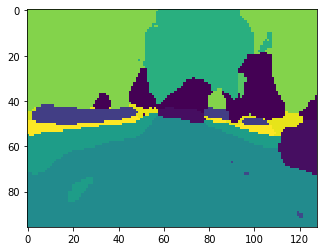

In [5]:
import base64

pred_decoded_byte = base64.decodebytes(bytes(response["base64_prediction"], encoding="utf-8"))
pred_decoded = np.reshape(
    np.frombuffer(pred_decoded_byte, dtype=np.uint8), (96, 128)
)
plt.imshow(pred_decoded);